# Dataset
In this notebook we'll perform tests on the SIS Dataset.

In [5]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0,'../')

from datasets import load_dataset,load_from_disk
from torchvision.transforms import Compose,Resize,ToTensor,Normalize

hf_dir_path = "/mnt/c/BUSDATA/Datasets/CelebAMask-HQ/hf/"
dataset = load_from_disk(hf_dir_path)

img_size = 256
def transform(examples):
    resize = Resize(img_size)
    transforms_img = Compose([
        resize,
        ToTensor(),
        Normalize(0.5,0.5)
    ])

    examples["image"] = [transforms_img(image.convert("RGB")) for image in examples["image"]]
    examples["annotation"] = [np.array(resize(image)) for image in examples["annotation"]]
    return examples
dataset.set_transform(transform)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from examples.community.semantic_image_synthesis.src.pipelines.semantic_only_diffusion import SemanticOnlyDDMPipeline
from examples.community.semantic_image_synthesis.src.models.unet_2d_sis import UNet2DSISModel
from diffusers.schedulers import DDPMScheduler
import os
#model_dir_path = "/mnt/c/BUSDATA/Datasets/CelebAMask-HQ/models/256x256px/checkpoint-11000"
model_dir_path = "/mnt/c/BUSDATA/Datasets/CelebAMask-HQ/models/sis/256x256px/linear/checkpoint-95000/"

model = UNet2DSISModel.from_pretrained(os.path.join(model_dir_path,'unet'))
scheduler = DDPMScheduler(variance_type='learned_range',beta_schedule='linear')
pipeline = SemanticOnlyDDMPipeline(model,scheduler)

pipeline=pipeline.to('cuda')


100%|██████████| 50/50 [00:14<00:00,  3.46it/s]


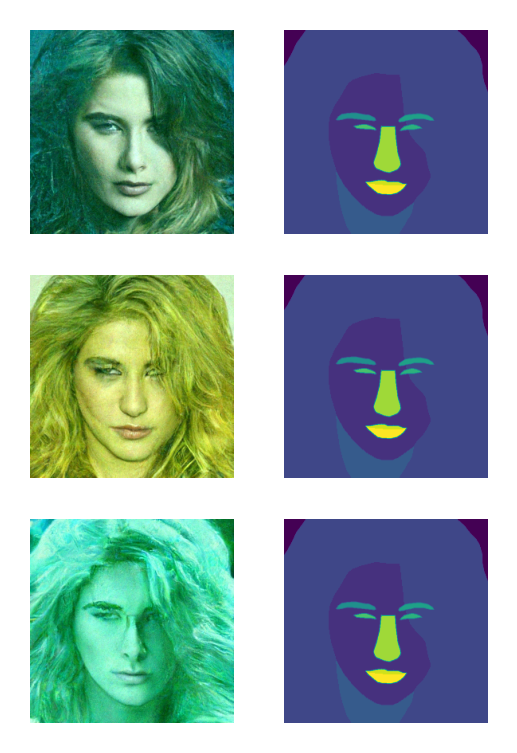

In [7]:
import torch
import matplotlib.pyplot as plt

#scheduler = DDPMScheduler(variance_type='learned_range',beta_schedule='squaredcos_cap_v2')
scheduler = DDPMScheduler(variance_type='learned_range',beta_schedule='linear',thresholding=False)
pipeline.scheduler = scheduler
index = 77
x= dataset['test'][index]['image']
y = dataset['test'][index]['annotation']
n_samples = 3
fig,ax=plt.subplots(n_samples,2,figsize=(2,n_samples),dpi=300)
generator = torch.Generator(device='cuda').manual_seed(42)
for i in range(n_samples):
    with torch.autocast(device_type="cuda",dtype=torch.float16):
        img = pipeline(segmap=torch.tensor(y).unsqueeze(0),num_inference_steps=50,generator=generator,guidance_scale=1.5)
    ax[i,0].imshow(img.images[0])
    ax[i,0].set_axis_off()
    ax[i,1].imshow(y)
    ax[i,1].set_axis_off()

plt.show()

In this try, well generate the same image with different scales...

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np

#scheduler = DDPMScheduler(variance_type='learned_range',beta_schedule='squaredcos_cap_v2')
scheduler = DDPMScheduler(variance_type='learned_range',beta_schedule='linear',thresholding=False)
pipeline.scheduler = scheduler
index = 77
x= dataset['test'][index]['image']
y = dataset['test'][index]['annotation']
n_samples = 5
fig,ax=plt.subplots(n_samples,2,figsize=(2,n_samples),dpi=300)
scale = np.linspace(1.5,10,n_samples)
for i in range(n_samples):
    generator = torch.Generator(device='cuda').manual_seed(42)
    with torch.autocast(device_type="cuda",dtype=torch.float16):
        img = pipeline(segmap=torch.tensor(y).unsqueeze(0),num_inference_steps=50,generator=generator,guidance_scale=scale[i])
    ax[i,0].imshow(img.images[0])
    ax[i,0].set_axis_off()
    ax[i,1].imshow(y)
    ax[i,1].set_axis_off()

plt.show()

KeyError: "Invalid key: 77. Please first select a split. For example: `my_dataset_dictionary['train'][77]`. Available splits: ['test', 'train']"